<a href="https://colab.research.google.com/github/Yewon9/Emotion_Recognition_STT/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mode, StatisticsError
from sklearn.utils import resample
import seaborn as sns

# DATA - 일반 음성

## ETRI

In [43]:
all_data = []

In [44]:
for i in range(1, 41):
  sess_num = f'Sess{i:02d}'
  csv_path = f'/content/drive/MyDrive/project/KEMDy20/annotation/{sess_num}_eval.csv'

  data = pd.read_csv(csv_path)

  data = data.iloc[:, [3, 4]]
  data.rename(columns = {data.columns[0]: 'Path', data.columns[1]: 'Emotion'}, inplace = True)

  data.drop(data.index[0], inplace = True)

  session_num = f'Session{i:02d}'
  data['Path'] = data['Path'].apply(lambda x: f'/content/drive/MyDrive/project/KEMDy20/wav/{session_num}/{x}.wav')

  all_data.append(data)

In [45]:
etri = pd.concat(all_data, ignore_index = True)
print(etri)

                                                    Path  Emotion
0      /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
1      /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
2      /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
3      /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
4      /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
...                                                  ...      ...
13457  /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
13458  /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
13459  /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
13460  /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral
13461  /content/drive/MyDrive/project/KEMDy20/wav/Ses...  neutral

[13462 rows x 2 columns]


In [46]:
etri = etri[etri['Path'].apply(lambda x: os.path.exists(x))]
etri.shape

(13462, 2)

In [47]:
unique_emotions = etri['Emotion'].unique()
print(unique_emotions)

['neutral' 'happy' 'happy;neutral' 'surprise;neutral' 'happy;surprise'
 'angry;neutral' 'surprise' 'angry' 'neutral;sad' 'disqust'
 'neutral;disqust' 'sad' 'fear' 'neutral;fear' 'happy;fear'
 'angry;disqust' 'neutral;disqust;sad' 'angry;neutral;disqust;fear;sad'
 'happy;sad' 'happy;surprise;neutral' 'angry;neutral;disqust'
 'happy;angry;neutral' 'happy;neutral;disqust' 'happy;neutral;fear']


In [48]:
etri = etri[~etri['Emotion'].str.contains(';', na = False)]
unique_emotions = etri['Emotion'].unique()
print(unique_emotions)

['neutral' 'happy' 'surprise' 'angry' 'disqust' 'sad' 'fear']


In [49]:
etri

,Path,Emotion
0,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
1,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
2,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
3,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
4,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
...,...,...
13457,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
13458,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
13459,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral
13460,/content/drive/MyDrive/project/KEMDy20/wav/Ses...,neutral


In [51]:
etri.to_csv('etri.csv', index = False)

## AIHUB

### aihub_4

In [11]:
aihub_4 = pd.read_csv('/content/drive/MyDrive/project/data_aihub/4.csv', encoding = 'CP949')
aihub_4.head()

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,4번감정세기,5번 감정,5번 감정세기,나이,성별
0,5e258fd1305bcf3ad153a6a4,"어, 청소 니가 대신 해 줘!",anger,Neutral,0,Angry,1,Neutral,0,Neutral,0,Angry,1,27,male
1,5e258fe2305bcf3ad153a6a5,둘 다 청소 하기 싫어. 귀찮아.,anger,Neutral,0,Angry,1,Neutral,0,Neutral,0,Angry,1,27,male
2,5e258ff5305bcf3ad153a6a6,둘 다 하기 싫어서 화내.,anger,Angry,1,Angry,1,Neutral,0,Angry,1,Angry,1,27,male
3,5e25902f305bcf3ad153a6a9,그럼 방세는 어떡해.,anger,Sadness,1,Sadness,1,Sadness,1,Sadness,1,Sadness,1,27,male
4,5e27f90b5807b852d9e0157b,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,sad,Sadness,1,Sadness,1,Sadness,1,Sadness,2,Sadness,1,32,male


In [12]:
aihub_4.shape

(14606, 15)

In [13]:
def determine_majority(row):
  try:
    return mode(row[['1번 감정', '2번 감정', '3번 감정', '4번 감정', '5번 감정']].tolist())
  except StatisticsError:
    return None

In [14]:
aihub_4['Emotion'] = aihub_4.apply(determine_majority, axis = 1)

In [15]:
aihub_4 = aihub_4.dropna(subset = ['Emotion'])
print(aihub_4)

                         wav_id  \
0      5e258fd1305bcf3ad153a6a4   
1      5e258fe2305bcf3ad153a6a5   
2      5e258ff5305bcf3ad153a6a6   
3      5e25902f305bcf3ad153a6a9   
4      5e27f90b5807b852d9e0157b   
...                         ...   
14601  5e53d6067bef803b4851dfc6   
14602  5e53d61cc38c123b9ec6dde6   
14603  5e53d6332a2d173b73a03210   
14604  5e53d659963e443aee02b7d0   
14605  5e53d6778849ac3aacea576f   

                                                     발화문     상황    1번 감정  \
0                                       어, 청소 니가 대신 해 줘!  anger  Neutral   
1                                     둘 다 청소 하기 싫어. 귀찮아.  anger  Neutral   
2                                         둘 다 하기 싫어서 화내.  anger    Angry   
3                                            그럼 방세는 어떡해.  anger  Sadness   
4                              권태긴줄 알았는데 다른 사람이 생겼나보더라고.    sad  Sadness   
...                                                  ...    ...      ...   
14601                             아, 요즘 룸메랑 너무 

In [16]:
front = aihub_4.iloc[:, :2]
back = aihub_4.iloc[:, -1:]

In [17]:
aihub_4 = pd.concat([front, back], axis = 1)
aihub_4.head()

,wav_id,발화문,Emotion
0,5e258fd1305bcf3ad153a6a4,"어, 청소 니가 대신 해 줘!",Neutral
1,5e258fe2305bcf3ad153a6a5,둘 다 청소 하기 싫어. 귀찮아.,Neutral
2,5e258ff5305bcf3ad153a6a6,둘 다 하기 싫어서 화내.,Angry
3,5e25902f305bcf3ad153a6a9,그럼 방세는 어떡해.,Sadness
4,5e27f90b5807b852d9e0157b,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,Sadness


In [18]:
aihub_4['Path'] = '/content/drive/MyDrive/project/data_aihub/4/' + aihub_4['wav_id'] + '.wav'
aihub_4.head()

,wav_id,발화문,Emotion,Path
0,5e258fd1305bcf3ad153a6a4,"어, 청소 니가 대신 해 줘!",Neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
1,5e258fe2305bcf3ad153a6a5,둘 다 청소 하기 싫어. 귀찮아.,Neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
2,5e258ff5305bcf3ad153a6a6,둘 다 하기 싫어서 화내.,Angry,/content/drive/MyDrive/project/data_aihub/4/5e...
3,5e25902f305bcf3ad153a6a9,그럼 방세는 어떡해.,Sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
4,5e27f90b5807b852d9e0157b,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,Sadness,/content/drive/MyDrive/project/data_aihub/4/5e...


### aihub_5

In [19]:
aihub_5 = pd.read_csv('/content/drive/MyDrive/project/data_aihub/5.csv', encoding = 'CP949')
aihub_5.head()

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,4번감정세기,5번 감정,5번 감정세기,나이,성별
0,5ed10dbc2880d70f286121c3,개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.,disgust,Angry,2,Angry,2,Angry,2,Angry,2,Angry,2,33,female
1,5ecb60ef9aa8ea0eec53edb1,지금도 그대로 있어. 치우는 사람이 없어.,disgust,Neutral,0,Disgust,2,Sadness,2,Disgust,2,Disgust,1,48,female
2,5f052858b140144dfcfef768,맞아. 무기력증인 것 같아. 한동안 정말 바빴었거든.,sad,Sadness,2,Sadness,1,Sadness,2,Sadness,2,Sadness,2,48,female
3,5f0e72c4b140144dfcff3fa5,오늘이 발표날인데 연락이 없더라고. 그래서 알아봤더니 명단에 내 이름이 없대.,sad,Sadness,1,Sadness,2,Sadness,2,Sadness,2,Sadness,2,48,female
4,5ed10ddd7e21a10eee2537ce,그치. 개 키우는 사람이 늘어나니까 그만큼 버리는 사람도 늘어나는 거야!,disgust,Angry,2,Angry,2,Angry,2,Angry,2,Sadness,2,33,female


In [20]:
aihub_5.shape

(10011, 15)

In [21]:
aihub_5['Emotion'] = aihub_5.apply(determine_majority, axis = 1)

In [22]:
aihub_5 = aihub_5.dropna(subset = ['Emotion'])
print(aihub_5)

                         wav_id  \
0      5ed10dbc2880d70f286121c3   
1      5ecb60ef9aa8ea0eec53edb1   
2      5f052858b140144dfcfef768   
3      5f0e72c4b140144dfcff3fa5   
4      5ed10ddd7e21a10eee2537ce   
...                         ...   
10006  5f05ffd5b140144dfcff01c7   
10007  5ec53bf82880d70f28611de0   
10008  5f0b2b5ab140144dfcff2759   
10009  5f0b2b75b140144dfcff275a   
10010  5f0527b3b140144dfcfef75e   

                                                     발화문       상황    1번 감정  \
0              개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.  disgust    Angry   
1                                지금도 그대로 있어. 치우는 사람이 없어.  disgust  Neutral   
2                          맞아. 무기력증인 것 같아. 한동안 정말 바빴었거든.      sad  Sadness   
3            오늘이 발표날인데 연락이 없더라고. 그래서 알아봤더니 명단에 내 이름이 없대.      sad  Sadness   
4               그치. 개 키우는 사람이 늘어나니까 그만큼 버리는 사람도 늘어나는 거야!  disgust    Angry   
...                                                  ...      ...      ...   
10006  너의 말 대로 약속 장소를 옮겨 보는 것도 좋은

In [23]:
front = aihub_5.iloc[:, :2]
back = aihub_5.iloc[:, -1:]

In [24]:
aihub_5 = pd.concat([front, back], axis = 1)
aihub_5.head()

,wav_id,발화문,Emotion
0,5ed10dbc2880d70f286121c3,개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.,Angry
1,5ecb60ef9aa8ea0eec53edb1,지금도 그대로 있어. 치우는 사람이 없어.,Disgust
2,5f052858b140144dfcfef768,맞아. 무기력증인 것 같아. 한동안 정말 바빴었거든.,Sadness
3,5f0e72c4b140144dfcff3fa5,오늘이 발표날인데 연락이 없더라고. 그래서 알아봤더니 명단에 내 이름이 없대.,Sadness
4,5ed10ddd7e21a10eee2537ce,그치. 개 키우는 사람이 늘어나니까 그만큼 버리는 사람도 늘어나는 거야!,Angry


In [25]:
aihub_5['Path'] = '/content/drive/MyDrive/project/data_aihub/5/' + aihub_5['wav_id'] + '.wav'
aihub_5.head()

,wav_id,발화문,Emotion,Path
0,5ed10dbc2880d70f286121c3,개를 예쁘다고 사놓고 끝까지 키우지도 않고 버리는 사람들이 엄청 많아졌대.,Angry,/content/drive/MyDrive/project/data_aihub/5/5e...
1,5ecb60ef9aa8ea0eec53edb1,지금도 그대로 있어. 치우는 사람이 없어.,Disgust,/content/drive/MyDrive/project/data_aihub/5/5e...
2,5f052858b140144dfcfef768,맞아. 무기력증인 것 같아. 한동안 정말 바빴었거든.,Sadness,/content/drive/MyDrive/project/data_aihub/5/5f...
3,5f0e72c4b140144dfcff3fa5,오늘이 발표날인데 연락이 없더라고. 그래서 알아봤더니 명단에 내 이름이 없대.,Sadness,/content/drive/MyDrive/project/data_aihub/5/5f...
4,5ed10ddd7e21a10eee2537ce,그치. 개 키우는 사람이 늘어나니까 그만큼 버리는 사람도 늘어나는 거야!,Angry,/content/drive/MyDrive/project/data_aihub/5/5e...


### aihub_5_2

In [26]:
aihub_5_2 = pd.read_csv('/content/drive/MyDrive/project/data_aihub/5_2.csv', encoding = 'CP949')
aihub_5_2.head()

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,4번감정세기,5번 감정,5번 감정세기,나이,성별
0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,happiness,angry,2,surprise,2,happiness,2,happiness,2,happiness,2,48,female
1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,happiness,neutral,0,happiness,2,happiness,2,happiness,2,happiness,2,48,female
2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",happiness,angry,2,happiness,2,happiness,2,happiness,2,happiness,2,48,female
3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",happiness,angry,2,happiness,2,happiness,2,happiness,2,happiness,1,48,female
4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral,happiness,2,happiness,1,happiness,2,happiness,1,happiness,1,48,female


In [27]:
aihub_5_2.shape

(19374, 15)

In [28]:
aihub_5_2['Emotion'] = aihub_5_2.apply(determine_majority, axis = 1)

In [29]:
aihub_5_2 = aihub_5_2.dropna(subset = ['Emotion'])
print(aihub_5_2)

                         wav_id  \
0      5f4141e29dd513131eacee2f   
1      5f4141f59dd513131eacee30   
2      5f4142119dd513131eacee31   
3      5f4142279dd513131eacee32   
4      5f3c9ed98a3c1005aa97c4bd   
...                         ...   
19369  5fbe313c44697678c497c05a   
19370  5fbe251044697678c497bfb8   
19371  5fbe31584c55eb78bd7cee7f   
19372  5fbe2f8544697678c497c047   
19373  5fbe36714c55eb78bd7ceea3   

                                                     발화문         상황  \
0                                       헐! 나 이벤트에 당첨 됐어.  happiness   
1            내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.  happiness   
2                            한 명 뽑는 거였는데, 그게 바로 내가 된 거야.  happiness   
3      당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...  happiness   
4                       에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.    neutral   
...                                                  ...        ...   
19369                                      나 엘리베이터에 갇혔어.       fear   
19370      

In [30]:
front = aihub_5_2.iloc[:, :2]
back = aihub_5_2.iloc[:, -1:]

In [31]:
aihub_5_2 = pd.concat([front, back], axis = 1)
aihub_5_2.head()

,wav_id,발화문,Emotion
0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,happiness
1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,happiness
2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",happiness
3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",happiness
4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,happiness


In [32]:
aihub_5_2['Path'] = '/content/drive/MyDrive/project/data_aihub/5_2/' + aihub_5_2['wav_id'] + '.wav'
aihub_5_2.head()

,wav_id,발화문,Emotion,Path
0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,happiness,/content/drive/MyDrive/project/data_aihub/5_2/...
1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,happiness,/content/drive/MyDrive/project/data_aihub/5_2/...
2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",happiness,/content/drive/MyDrive/project/data_aihub/5_2/...
3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",happiness,/content/drive/MyDrive/project/data_aihub/5_2/...
4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,happiness,/content/drive/MyDrive/project/data_aihub/5_2/...


### aihub

In [33]:
aihub = pd.concat([aihub_4, aihub_5, aihub_5_2], axis = 0)
aihub

,wav_id,발화문,Emotion,Path
0,5e258fd1305bcf3ad153a6a4,"어, 청소 니가 대신 해 줘!",Neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
1,5e258fe2305bcf3ad153a6a5,둘 다 청소 하기 싫어. 귀찮아.,Neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
2,5e258ff5305bcf3ad153a6a6,둘 다 하기 싫어서 화내.,Angry,/content/drive/MyDrive/project/data_aihub/4/5e...
3,5e25902f305bcf3ad153a6a9,그럼 방세는 어떡해.,Sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
4,5e27f90b5807b852d9e0157b,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,Sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
...,...,...,...,...
19369,5fbe313c44697678c497c05a,나 엘리베이터에 갇혔어.,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...
19370,5fbe251044697678c497bfb8,하지만 기분이 나쁜 걸 어떡해?,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...
19371,5fbe31584c55eb78bd7cee7f,자취방 엘리베이턴데 정전인가봐.,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...
19372,5fbe2f8544697678c497c047,나 드디어 프로젝트 끝났어!,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...


In [34]:
aihub.shape

(43991, 4)

In [35]:
aihub = aihub.drop_duplicates(subset = '발화문')
aihub.shape

(37212, 4)

In [36]:
emotion_counts = aihub['Emotion'].value_counts()
emotion_counts

,count
Emotion,
Sadness,11088
Angry,5410
neutral,5233
sadness,3021
happiness,2981
Neutral,1780
angry,1700
Fear,1396
disgust,1320


In [37]:
aihub['Emotion'] = aihub['Emotion'].str.lower()

<ipython-input-37-825f5e21d148>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aihub['Emotion'] = aihub['Emotion'].str.lower()


In [38]:
emotion_counts = aihub['Emotion'].value_counts()
emotion_counts

,count
Emotion,
sadness,14109
angry,7110
neutral,7013
happiness,3250
disgust,2451
fear,2325
surprise,954


In [39]:
aihub.shape

(37212, 4)

In [40]:
aihub = aihub[aihub['Path'].apply(lambda x: os.path.exists(x))]
aihub.shape

(37163, 4)

In [41]:
aihub = aihub.iloc[:, [2, 3]]
aihub = aihub.rename(columns = {'감정' : 'Emotions', 'Path' : 'Path'})
aihub

,Emotion,Path
4,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
5,neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
6,disgust,/content/drive/MyDrive/project/data_aihub/4/5e...
7,neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
8,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
...,...,...
19366,neutral,/content/drive/MyDrive/project/data_aihub/5_2/...
19367,neutral,/content/drive/MyDrive/project/data_aihub/5_2/...
19368,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...
19370,sadness,/content/drive/MyDrive/project/data_aihub/5_2/...


In [42]:
aihub.to_csv('aihub.csv', index = False, encoding = 'utf-8-sig')

## ETRI + AIHUB

In [52]:
data_aihub = pd.read_csv('aihub.csv')
data_etri = pd.read_csv('etri.csv')

In [53]:
data = pd.concat([data_aihub, data_etri], axis = 0)
data

,Emotion,Path
0,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
1,neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
2,disgust,/content/drive/MyDrive/project/data_aihub/4/5e...
3,neutral,/content/drive/MyDrive/project/data_aihub/4/5e...
4,sadness,/content/drive/MyDrive/project/data_aihub/4/5e...
...,...,...
12823,neutral,/content/drive/MyDrive/project/KEMDy20/wav/Ses...
12824,neutral,/content/drive/MyDrive/project/KEMDy20/wav/Ses...
12825,neutral,/content/drive/MyDrive/project/KEMDy20/wav/Ses...
12826,neutral,/content/drive/MyDrive/project/KEMDy20/wav/Ses...


In [54]:
emotion_counts = data['Emotion'].value_counts()
emotion_counts

,count
Emotion,
neutral,18124
sadness,14087
angry,7248
happiness,3240
disgust,2451
fear,2368
happy,1183
surprise,1108
sad,121


In [55]:
data['Emotion'].replace({'sadness': 'sad', 'happiness': 'happy'}, inplace = True)

<ipython-input-55-6836602b2ee0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Emotion'].replace({'sadness': 'sad', 'happiness': 'happy'}, inplace = True)


In [56]:
emotion_counts = data['Emotion'].value_counts()
emotion_counts

,count
Emotion,
neutral,18124
sad,14208
angry,7248
happy,4423
disgust,2451
fear,2368
surprise,1108
disqust,61


In [57]:
min_samples = 100
target_sample_size = 2000

In [58]:
data = data[data['Emotion'].map(emotion_counts).fillna(0) > min_samples]

In [59]:
data_emotion_balacned = pd.DataFrame()
for emotion in data['Emotion'].unique():
  emotion_data = data[data['Emotion'] == emotion]

  if len(emotion_data) > target_sample_size:
    emotion_data = resample(emotion_data, replace = False, n_samples = target_sample_size, random_state = 42)

  data_emotion_balacned = pd.concat([data_emotion_balacned, emotion_data])

print(data_emotion_balacned['Emotion'].value_counts())

Emotion
sad         2000
neutral     2000
disgust     2000
angry       2000
fear        2000
happy       2000
surprise    1108
Name: count, dtype: int64


In [60]:
data_emotion_balacned = data_emotion_balacned.reset_index(drop = True)
data_emotion_balacned

,Emotion,Path
0,sad,/content/drive/MyDrive/project/data_aihub/5/5e...
1,sad,/content/drive/MyDrive/project/data_aihub/4/5e...
2,sad,/content/drive/MyDrive/project/data_aihub/5_2/...
3,sad,/content/drive/MyDrive/project/data_aihub/5/5f...
4,sad,/content/drive/MyDrive/project/data_aihub/5_2/...
...,...,...
13103,happy,/content/drive/MyDrive/project/data_aihub/5_2/...
13104,happy,/content/drive/MyDrive/project/data_aihub/5_2/...
13105,happy,/content/drive/MyDrive/project/data_aihub/5_2/...
13106,happy,/content/drive/MyDrive/project/data_aihub/5/5e...


In [61]:
data_emotion_balacned.to_csv('data_emotion_balanced.csv', index = False, encoding = 'utf-8-sig')

## EDA

In [62]:
data_emotion_balanced = pd.read_csv('data_emotion_balanced.csv')

In [ ]:
tqdm.pandas()

def get_audio_length(file_path):
  try:
    y, sr = librosa.load(file_path, sr = None)
    return librosa.get_duration(y = y, sr= sr)
  except:
    return None

In [ ]:
data_emotion_balacned['Length'] = data_emotion_balacned['Path'].progress_apply(get_audio_length)

100%|██████████| 13110/13110 [1:11:26<00:00,  3.06it/s]


In [ ]:
mean_length = data_emotion_balacned['Length'].mean()
median_length = data_emotion_balacned['Length'].median()
min_length = data_emotion_balacned['Length'].min()
max_length = data_emotion_balacned['Length'].max()

print(f"평균 길이: {mean_length:.2f}초")
print(f"중앙값 길이: {median_length:.2f}초")
print(f"최소 길이: {min_length:.2f}초")
print(f"최대 길이: {max_length:.2f}초")

평균 길이: 6.21초
중앙값 길이: 5.59초
최소 길이: 0.79초
최대 길이: 41.51초


In [ ]:
q1 = data_emotion_balacned['Length'].quantile(0.25)
q3 = data_emotion_balacned['Length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data_emotion_balacned[(data_emotion_balacned['Length'] < lower_bound) | (data_emotion_balacned['Length'] > upper_bound)]
print(f"이상값 개수: {len(outliers)}")

이상값 개수: 452


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

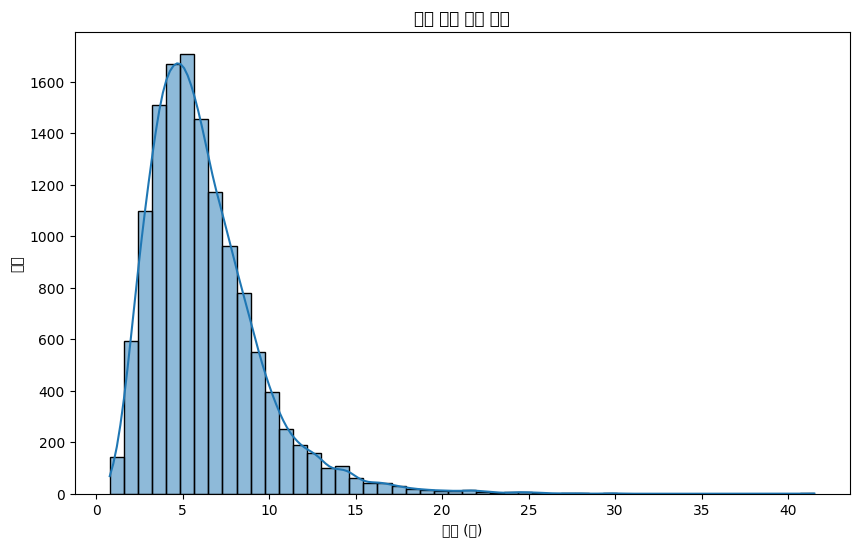

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data_emotion_balacned['Length'], bins=50, kde=True)
plt.title('음성 파일 길이 분포')
plt.xlabel('길이 (초)')
plt.ylabel('빈도')
plt.show()

In [ ]:
data_emotion_filtered = data_emotion_balacned[data_emotion_balacned['Length'] <= upper_bound]

print(f"필터링 후 데이터 개수: {len(data_emotion_filtered)}")
print(data_emotion_filtered)

필터링 후 데이터 개수: 12658
       Emotion                                               Path     Length
0      neutral  /content/drive/MyDrive/project/KEMDy20/wav/Ses...   2.687000
1      neutral  /content/drive/MyDrive/project/KEMDy20/wav/Ses...   9.403000
3      neutral  /content/drive/MyDrive/project/data_aihub/5_2/...   5.760000
4      neutral  /content/drive/MyDrive/project/KEMDy20/wav/Ses...   1.962000
5      neutral  /content/drive/MyDrive/project/KEMDy20/wav/Ses...   9.705000
...        ...                                                ...        ...
13105    happy  /content/drive/MyDrive/project/data_aihub/5_2/...   4.693333
13106    happy  /content/drive/MyDrive/project/data_aihub/5_2/...  10.240000
13107    happy  /content/drive/MyDrive/project/KEMDy20/wav/Ses...   8.725000
13108    happy  /content/drive/MyDrive/project/data_aihub/5_2/...   6.912000
13109    happy  /content/drive/MyDrive/project/data_aihub/5_2/...   5.461333

[12658 rows x 3 columns]


In [ ]:
data_emotion_filtered = data_emotion_filtered.iloc[:, [0, 1]]
data_emotion_filtered

In [ ]:
data_emotion_filtered = data_emotion_filtered[data_emotion_filtered['Path'].apply(lambda x: os.path.exists(x))]
data_emotion_filtered.shape

In [ ]:
data_emotion_filtered.to_csv('data_emotion.csv', index = False)

# DATA - 구음 장애 음성

In [63]:
audio_folder_path = '/content/drive/MyDrive/project/aihub_data_main/'

In [64]:
audio_files = []

for file_name in os.listdir(audio_folder_path):
  if file_name.endswith('.wav'):
    full_path = os.path.join(audio_folder_path, file_name)
    audio_files.append(full_path)

In [65]:
data_main = pd.DataFrame(audio_files, columns = ['Path'])

In [66]:
print(data_main)

                                                  Path
0    /content/drive/MyDrive/project/aihub_data_main...
1    /content/drive/MyDrive/project/aihub_data_main...
2    /content/drive/MyDrive/project/aihub_data_main...
3    /content/drive/MyDrive/project/aihub_data_main...
4    /content/drive/MyDrive/project/aihub_data_main...
..                                                 ...
418  /content/drive/MyDrive/project/aihub_data_main...
419  /content/drive/MyDrive/project/aihub_data_main...
420  /content/drive/MyDrive/project/aihub_data_main...
421  /content/drive/MyDrive/project/aihub_data_main...
422  /content/drive/MyDrive/project/aihub_data_main...

[423 rows x 1 columns]


In [67]:
data_main.to_csv('data_main.csv', index = False)

## EDA

In [68]:
data_main = pd.read_csv('data_main.csv')

In [ ]:
tqdm.pandas()

def get_audio_length(file_path):
  try:
    y, sr = librosa.load(file_path, sr = None)
    return librosa.get_duration(y = y, sr= sr)
  except:
    return None

In [ ]:
data_main['Length'] = data_main['Path'].progress_apply(get_audio_length)

100%|██████████| 423/423 [40:32<00:00,  5.75s/it]


In [ ]:
mean_length = data_main['Length'].mean()
median_length = data_main['Length'].median()
min_length = data_main['Length'].min()
max_length = data_main['Length'].max()

print(f"평균 길이: {mean_length:.2f}초")
print(f"중앙값 길이: {median_length:.2f}초")
print(f"최소 길이: {min_length:.2f}초")
print(f"최대 길이: {max_length:.2f}초")

평균 길이: 2229.36초
중앙값 길이: 1686.97초
최소 길이: 36.42초
최대 길이: 30528.67초


In [ ]:
q1 = data_main['Length'].quantile(0.25)
q3 = data_main['Length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data_main[(data_main['Length'] < lower_bound) | (data_main['Length'] > upper_bound)]
print(f"이상값 개수: {len(outliers)}")

이상값 개수: 9


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

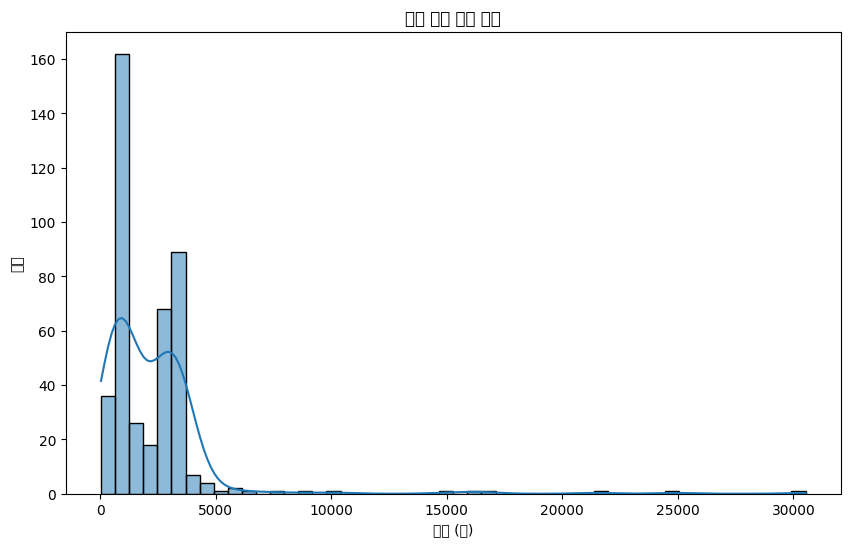

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data_main['Length'], bins=50, kde=True)
plt.title('음성 파일 길이 분포')
plt.xlabel('길이 (초)')
plt.ylabel('빈도')
plt.show()

In [ ]:
data_main_filtered = data_main[data_main['Length'] <= upper_bound]

print(f"필터링 후 데이터 개수: {len(data_main_filtered)}")
print(data_main_filtered)

필터링 후 데이터 개수: 414
                                                  Path       Length
0    /content/drive/MyDrive/project/aihub_data_main...   772.162925
1    /content/drive/MyDrive/project/aihub_data_main...   206.577052
2    /content/drive/MyDrive/project/aihub_data_main...   828.429841
3    /content/drive/MyDrive/project/aihub_data_main...   760.371791
4    /content/drive/MyDrive/project/aihub_data_main...   337.830522
..                                                 ...          ...
418  /content/drive/MyDrive/project/aihub_data_main...   321.508729
419  /content/drive/MyDrive/project/aihub_data_main...  2753.132104
420  /content/drive/MyDrive/project/aihub_data_main...  1813.098753
421  /content/drive/MyDrive/project/aihub_data_main...   819.560658
422  /content/drive/MyDrive/project/aihub_data_main...  4320.614917

[414 rows x 2 columns]


In [ ]:
data_main_filtered = data_main_filtered.iloc[:, 0]
data_main_filtered

In [ ]:
data_main_filtered = data_main_filtered[data_main_filtered['Path'].apply(lambda x: os.path.exists(x))]
data_main_filtered.shape

In [ ]:
data_main_filtered.to_csv('data_main.csv', index = False)